## Используется dataset c kaggle [Stanford Dogs Dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset/data)

##### Разархивировать данные в созданную папку data

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.image as mpimg
from PIL import Image, ImageStat, UnidentifiedImageError
import albumentations as A
import cv2
from xml.dom import minidom
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import shutil

2024-07-07 11:41:36.482838: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-07 11:41:36.725926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 11:41:36.850967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 11:41:36.851725: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-07 11:41:37.038352: I tensorflow/core/platform/cpu_feature_gua

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-07-07 11:41:45.220738: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-07 11:41:45.384334: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-07 11:41:45.384389: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


### 1) Проверка данных в директориях

In [6]:
IMAGE_DIR = 'data/images/Images'
ANNOTATE_DIR = 'data/annotations/Annotation'

In [7]:
breed_list = os.listdir(IMAGE_DIR)

In [14]:
annotate_list = os.listdir(ANNOTATE_DIR)

In [15]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    # v = v[v.index('-') + 1:].lower().replace('_', ' ')
    label_maps.update({v: i})
    label_maps_rev.update({i: v})
label_maps

{'n02110185-Siberian_husky': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02113799-standard_poodle': 2,
 'n02097130-giant_schnauzer': 3,
 'n02090721-Irish_wolfhound': 4,
 'n02085936-Maltese_dog': 5,
 'n02091831-Saluki': 6,
 'n02086079-Pekinese': 7,
 'n02110063-malamute': 8,
 'n02108551-Tibetan_mastiff': 9,
 'n02096437-Dandie_Dinmont': 10,
 'n02098413-Lhasa': 11,
 'n02102318-cocker_spaniel': 12,
 'n02099712-Labrador_retriever': 13,
 'n02095889-Sealyham_terrier': 14,
 'n02090379-redbone': 15,
 'n02112018-Pomeranian': 16,
 'n02102973-Irish_water_spaniel': 17,
 'n02088094-Afghan_hound': 18,
 'n02112350-keeshond': 19,
 'n02085620-Chihuahua': 20,
 'n02100877-Irish_setter': 21,
 'n02088364-beagle': 22,
 'n02110627-affenpinscher': 23,
 'n02105412-kelpie': 24,
 'n02086910-papillon': 25,
 'n02096585-Boston_bull': 26,
 'n02112706-Brabancon_griffon': 27,
 'n02091244-Ibizan_hound': 28,
 'n02105162-malinois': 29,
 'n02099849-Chesapeake_Bay_retriever': 30,
 'n02111277-Newfoundland': 31,
 'n02097474-Tibeta

In [16]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16, 16))
    img_dir = f"{IMAGE_DIR}/{breed}/"
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(n_to_show // 4 + 1, 4, i + 1)
        plt.imshow(img)
        plt.axis('off')

n02110185-Siberian_husky


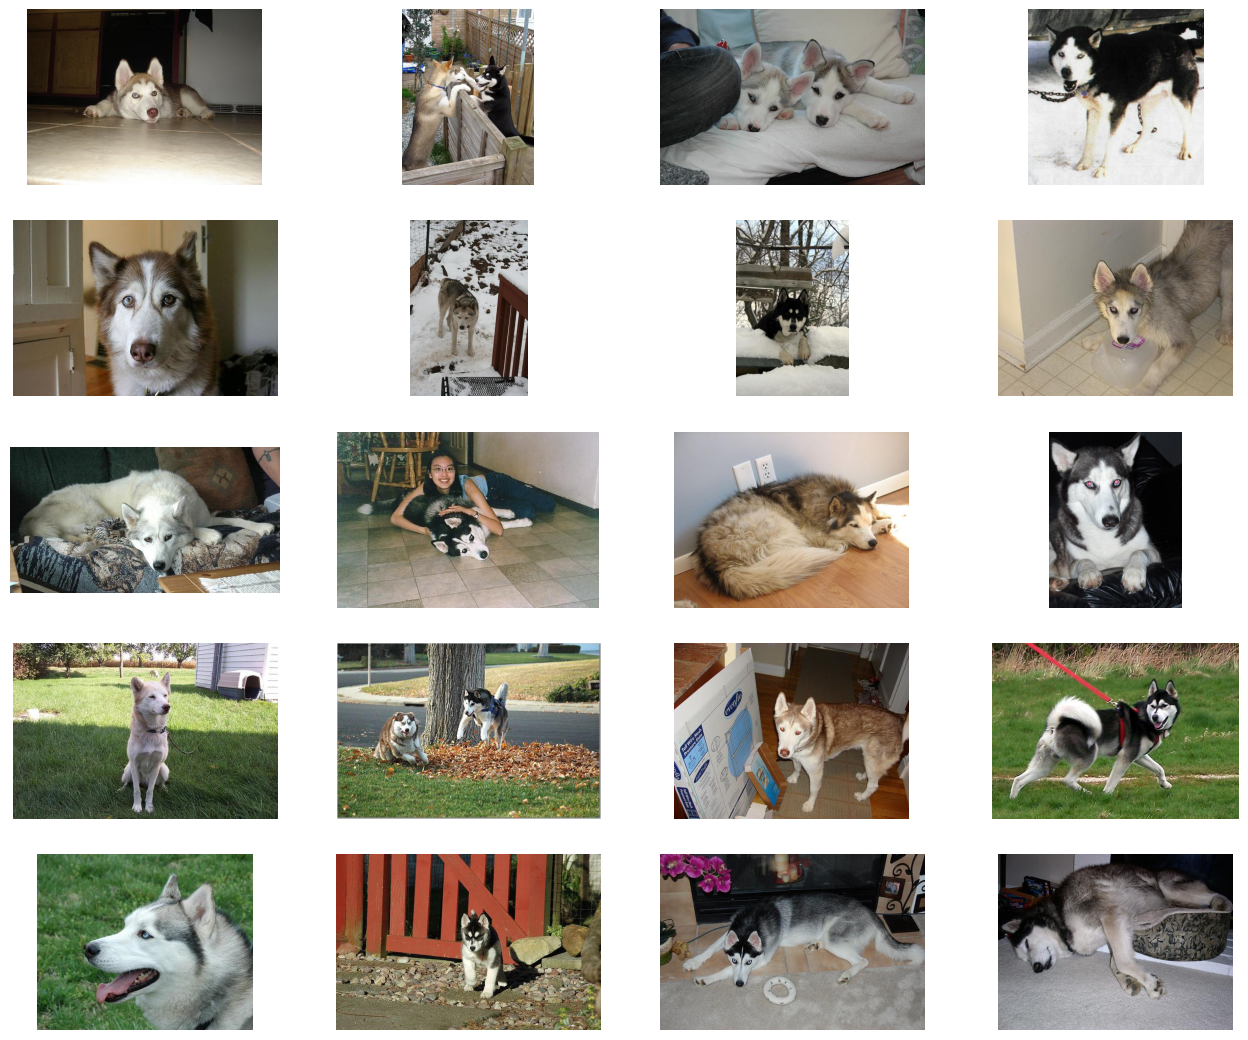

In [17]:
print(breed_list[0])
show_dir_images(breed_list[0], 20)

### 2) Преобразование данных из директорий в таблицу

In [18]:
def paths_and_labels():
    paths = []
    labels = []
    targets = []
    bbox = []

    for breed in breed_list:
        image_dir = f"{IMAGE_DIR}/{breed}/"
        annotation_dir = f"{ANNOTATE_DIR}/{breed}/"

        for img_name in os.listdir(image_dir):
            paths.append(os.path.join(image_dir, img_name))
            labels.append(breed)
            targets.append(label_maps[breed])
            bbox.append(os.path.join(annotation_dir, img_name[:-4]))

    return paths, labels, targets, bbox

In [19]:
paths, labels, targets, bbox = paths_and_labels()

In [20]:
data = pd.DataFrame({'path': paths, 'label': labels, 'target': targets, 'bbox_paths': bbox})

In [21]:
# data['label'] = data['label'].apply(lambda x: x[x.index('-') + 1:].lower().replace('_', ' '))

In [22]:
len(data['label'].unique())

120

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20580 entries, 0 to 20579
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        20580 non-null  object
 1   label       20580 non-null  object
 2   target      20580 non-null  int64 
 3   bbox_paths  20580 non-null  object
dtypes: int64(1), object(3)
memory usage: 643.2+ KB


In [24]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    size = root.find('size')
    width = int(float(size.find('width').text))
    height = int(float(size.find('height').text))

    objects = root.findall('object')
    annotations = []

    for obj in objects:
        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))

        annotations.append([xmin, ymin, xmax, ymax])  # width, height

    return np.array(annotations)

In [25]:
data['bbox'] = data['bbox_paths'].apply(parse_annotation)

In [26]:
data.head()

,path,label,target,bbox_paths,bbox
0,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[117, 102, 398, 244]]"
1,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[158, 130, 373, 433], [0, 130, 195, 457]]"
2,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[103, 64, 292, 237], [121, 55, 483, 228]]"
3,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[48, 39, 497, 489]]"
4,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[145, 22, 386, 332]]"


### 3) Фильтрация фотографий на основе нахождения ограничивающих рамок внутри фотографии

In [27]:
def are_bboxes_within_image(image, bboxes):
    image_height, image_width = image.shape[:2]

    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        if xmin < 0 or ymin < 0 or xmax > image_width or ymax > image_height:
            return False
    return True


def delete_files(image_path, xml_path):
    try:
        if os.path.exists(image_path):
            os.remove(image_path)
            print(f"Удалено изображение: {image_path}")
        if os.path.exists(xml_path):
            os.remove(xml_path)
            print(f"Удален файл аннотации: {xml_path}")
    except Exception as e:
        print(f"Ошибка при удалении файлов: {e}")


def delete_files_if_bboxes_not_within_image(data):
    flag = False
    for i in range(len(data)):
        image_path = data.iloc[i, 0]
        bbox_path = data.iloc[i, -2]
        bbox = data.iloc[i, -1]

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if not are_bboxes_within_image(image, bbox):
            print(f"Bounding boxes выходят за пределы изображения для {image_path}. Удаление файлов...")
            flag = True
            delete_files(image_path, bbox_path)
    if flag:
        print('Все неподходящие изображения и ограничивающие рамки удалены')
    else:
        print('Все bounding boxes входят в пределы изображения')

In [28]:
delete_files_if_bboxes_not_within_image(data)

Bounding boxes выходят за пределы изображения для data/images/Images/n02106030-collie/n02106030_3948.jpg. Удаление файлов...
Удалено изображение: data/images/Images/n02106030-collie/n02106030_3948.jpg
Удален файл аннотации: data/annotations/Annotation/n02106030-collie/n02106030_3948
Bounding boxes выходят за пределы изображения для data/images/Images/n02098105-soft-coated_wheaten_terrier/n02098105_2063.jpg. Удаление файлов...
Удалено изображение: data/images/Images/n02098105-soft-coated_wheaten_terrier/n02098105_2063.jpg
Удален файл аннотации: data/annotations/Annotation/n02098105-soft-coated_wheaten_terrier/n02098105_2063
Все неподходящие изображения и ограничивающие рамки удалены


In [29]:
def table():
    paths, labels, targets, bbox = paths_and_labels()
    data = pd.DataFrame({'path': paths, 'label': labels, 'target': targets, 'bbox_paths': bbox})
    data['bbox'] = data['bbox_paths'].apply(parse_annotation)
    return data


data = table()
data.head()

,path,label,target,bbox_paths,bbox
0,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[117, 102, 398, 244]]"
1,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[158, 130, 373, 433], [0, 130, 195, 457]]"
2,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[103, 64, 292, 237], [121, 55, 483, 228]]"
3,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[48, 39, 497, 489]]"
4,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[145, 22, 386, 332]]"


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20578 entries, 0 to 20577
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        20578 non-null  object
 1   label       20578 non-null  object
 2   target      20578 non-null  int64 
 3   bbox_paths  20578 non-null  object
 4   bbox        20578 non-null  object
dtypes: int64(1), object(4)
memory usage: 804.0+ KB


#### Функция для обновления xml файла

In [31]:
def save_bboxes_to_xml(file_path, bbox_path, bboxes, image_shape):
    annotation = ET.Element('annotation')
    folder = ET.SubElement(annotation, 'folder')
    folder.text = os.path.basename(os.path.dirname(file_path))
    filename = ET.SubElement(annotation, "filename")
    filename.text = bbox_path.split('/')[-1]
    path = ET.SubElement(annotation, "path")
    path.text = file_path

    source = ET.SubElement(annotation, "source")
    database = ET.SubElement(source, "database")
    database.text = "Me"

    size = ET.SubElement(annotation, "size")
    width = ET.SubElement(size, "width")
    width.text = str(image_shape[1])
    height = ET.SubElement(size, "height")
    height.text = str(image_shape[0])
    depth = ET.SubElement(size, "depth")
    depth.text = str(image_shape[2])

    segmented = ET.SubElement(annotation, "segmented")
    segmented.text = "0"

    for bbox in bboxes:
        obj = ET.SubElement(annotation, "object")
        name = ET.SubElement(obj, "name")
        x = os.path.basename(os.path.dirname(file_path))
        name.text = x[x.index('-') + 1:].lower().replace('_', ' ')
        pose = ET.SubElement(obj, "pose")
        pose.text = "Unspecified"
        truncated = ET.SubElement(obj, "truncated")
        truncated.text = "0"
        difficult = ET.SubElement(obj, "difficult")
        difficult.text = "0"

        bndbox = ET.SubElement(obj, "bndbox")
        xmin = ET.SubElement(bndbox, "xmin")
        xmin.text = str(bbox[0])
        ymin = ET.SubElement(bndbox, "ymin")
        ymin.text = str(bbox[1])
        xmax = ET.SubElement(bndbox, "xmax")
        xmax.text = str(bbox[2])
        ymax = ET.SubElement(bndbox, "ymax")
        ymax.text = str(bbox[3])

    xml_str = minidom.parseString(ET.tostring(annotation)).toprettyxml(indent="   ")
    with open(file_path, "w") as f:
        f.write(xml_str)

### 4) Изменение размера фотографий и ограничивающих рамок

In [32]:
def resize_images_and_bboxes(data, new_size):
    for i in range(len(data)):
        image_path = data.loc[i, 'path']
        bbox_path = data.loc[i, 'bbox_paths']

        try:
            with Image.open(image_path) as img:
                original_size = img.size
                if img.mode == 'RGBA':
                    img = img.convert('RGB')
                resized_img = img.resize(new_size, Image.Resampling.LANCZOS)
                resized_img.save(image_path)
        except (UnidentifiedImageError, OSError) as e:
            print(f"Ошибка при обработке файла {image_path}: {e}")
            continue

        original_width, original_height = original_size
        new_width, new_height = new_size
        bboxes = data.loc[i, 'bbox']

        scaled_bboxes = []
        for bbox in bboxes:
            xmin, ymin, xmax, ymax = bbox
            xmin = int(xmin * new_width / original_width)
            ymin = int(ymin * new_height / original_height)
            xmax = int(xmax * new_width / original_width)
            ymax = int(ymax * new_height / original_height)
            scaled_bboxes.append([xmin, ymin, xmax, ymax])

        save_bboxes_to_xml(bbox_path, bbox_path, scaled_bboxes, (new_height, new_width, 3))

    print("Все изображения и ограничивающие рамки успешно преобразованы\nЗакомментируйте код для последующих запусков блокнота")

In [33]:
new_size = (640, 640)
#resize_images_and_bboxes(data, new_size)

Все изображения и ограничивающие рамки успешно преобразованы
Закомментируйте код для последующих запусков блокнота


In [34]:
data['bbox'] = data['bbox_paths'].apply(parse_annotation)

In [35]:
data.head()

,path,label,target,bbox_paths,bbox
0,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[149, 174, 509, 416]]"
1,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[269, 166, 636, 554], [0, 166, 332, 584]]"
2,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[131, 123, 373, 455], [154, 105, 618, 438]]"
3,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[60, 48, 621, 608]]"
4,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[185, 42, 494, 638]]"


In [36]:
'''
Для проверки, если появились неподходящие изображения после преобразования размеров
'''
delete_files_if_bboxes_not_within_image(data)

Все bounding boxes входят в пределы изображения


In [37]:
data = table()
data.head()

,path,label,target,bbox_paths,bbox
0,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[149, 174, 509, 416]]"
1,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[269, 166, 636, 554], [0, 166, 332, 584]]"
2,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[131, 123, 373, 455], [154, 105, 618, 438]]"
3,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[60, 48, 621, 608]]"
4,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[185, 42, 494, 638]]"


### 5) Аугментация данных с сохранением файлов 

In [39]:
def augment_image_and_bbox(image, bboxes):
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.4),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.3),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.2),
            A.GaussNoise(var_limit=(5.0, 20.0), p=0.2)
        ], p=0.5),
        A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05, p=0.2),
        A.CoarseDropout(max_holes=6, max_height=15, max_width=15, p=0.2),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.4) 
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    labels = ['dog' for _ in range(len(bboxes))]
    augmented = transform(image=image, bboxes=bboxes, labels=labels)
    return augmented['image'], augmented['bboxes']


def add_augmented_data(data):
    for i in range(len(data)):
        image_path = data.iloc[i, 0]
        bbox_path = data.iloc[i, -2]
        bbox = data.iloc[i, -1]

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        augmented_image, augmented_bboxes = augment_image_and_bbox(image, bbox)

        aug_image_name = os.path.basename(image_path).replace('.jpg', '_aug.jpg')
        aug_image_path = os.path.dirname(image_path) + '/' + aug_image_name
        cv2.imwrite(aug_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

        aug_xml_name = os.path.basename(bbox_path) + '_aug'
        aug_xml_path = os.path.dirname(bbox_path) + '/' + aug_xml_name
        save_bboxes_to_xml(aug_xml_path, bbox_path, augmented_bboxes, augmented_image.shape)
    print('Аугментация выполнена\nЗакомментируйте этот код, чтобы в дальнейшем запускать блокнот')

In [40]:
add_augmented_data(data)  

/home/zarzd/.local/lib/python3.10/site-packages/pydantic/main.py:363: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Аугментация выполнена
Закомментируйте этот код, чтобы в дальнейшем запускать блокнот


In [41]:
data = table()
data.head()

,path,label,target,bbox_paths,bbox
0,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[138, 29, 579, 581]]"
1,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[265, 93, 640, 640], [66, 0, 320, 489], [23, ..."
2,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[149, 174, 509, 416]]"
3,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[269, 166, 636, 554], [0, 166, 332, 584]]"
4,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[104, 74, 637, 637]]"


In [42]:
len(data)

41156

In [43]:
'''
Для проверки, если появились неподходящие изображения после преобразования размеров
'''
delete_files_if_bboxes_not_within_image(data)

Все bounding boxes входят в пределы изображения


In [44]:
data = table()
data.head()

,path,label,target,bbox_paths,bbox
0,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[138, 29, 579, 581]]"
1,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[265, 93, 640, 640], [66, 0, 320, 489], [23, ..."
2,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[149, 174, 509, 416]]"
3,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[269, 166, 636, 554], [0, 166, 332, 584]]"
4,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[104, 74, 637, 637]]"


In [45]:
len(data)

41156

### 6) Визуализация фотографии с ограничивающей рамкой

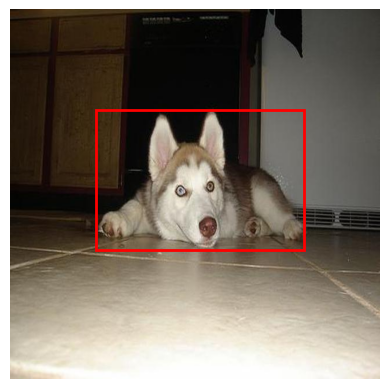

In [46]:
def visualize_bbox(image_path, bbox):
    image = mpimg.imread(image_path)

    plt.imshow(image)

    # Добавление bounding box
    for box in bbox:
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        rect = plt.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)  # Добавление прямоугольника к текущим осям
        plt.axis('off')  # для точного отображения цвета


index = 2
image_path = data.iloc[index, 0]  # Путь к изображению
bbox = data.iloc[index, -1]  # Bounding box для данного изображения

visualize_bbox(image_path, bbox)

In [47]:
def calculate_image_brightness(image_path):
    try:
        with Image.open(image_path) as img:
            # Преобразуем изображение в градации серого
            grayscale_image = img.convert('L')
            stat = ImageStat.Stat(grayscale_image)
            brightness = stat.mean[0]
            return brightness
    except (UnidentifiedImageError, OSError) as e:
        print(f"Ошибка при обработке файла {image_path}: {e}")
        return None


def delete_dark_images(data, brightness_threshold=35):
    flag = False
    for i in range(len(data)):
        image_path = data.iloc[i, 0]
        bbox_path = data.iloc[i, -2]

        brightness = calculate_image_brightness(image_path)
        if brightness is not None and brightness < brightness_threshold:
            print(f"Изображение {image_path} слишком тёмное (яркость: {brightness}). Удаление файлов...")
            flag = True
            delete_files(image_path, bbox_path)
    if flag:
        print('Все тёмные изображения удалены')
    else:
        print('Тёмные изображения не найдены')


# Применение функции
delete_dark_images(data)


Изображение data/images/Images/n02110185-Siberian_husky/n02110185_8162_aug.jpg слишком тёмное (яркость: 34.7008154296875). Удаление файлов...
Удалено изображение: data/images/Images/n02110185-Siberian_husky/n02110185_8162_aug.jpg
Удален файл аннотации: data/annotations/Annotation/n02110185-Siberian_husky/n02110185_8162_aug
Изображение data/images/Images/n02091831-Saluki/n02091831_7497_aug.jpg слишком тёмное (яркость: 34.69834228515625). Удаление файлов...
Удалено изображение: data/images/Images/n02091831-Saluki/n02091831_7497_aug.jpg
Удален файл аннотации: data/annotations/Annotation/n02091831-Saluki/n02091831_7497_aug
Изображение data/images/Images/n02098413-Lhasa/n02098413_20774_aug.jpg слишком тёмное (яркость: 19.40856689453125). Удаление файлов...
Удалено изображение: data/images/Images/n02098413-Lhasa/n02098413_20774_aug.jpg
Удален файл аннотации: data/annotations/Annotation/n02098413-Lhasa/n02098413_20774_aug
Изображение data/images/Images/n02098413-Lhasa/n02098413_20774.jpg слиш

In [48]:
data = table()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41092 entries, 0 to 41091
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        41092 non-null  object
 1   label       41092 non-null  object
 2   target      41092 non-null  int64 
 3   bbox_paths  41092 non-null  object
 4   bbox        41092 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.6+ MB


In [49]:
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,path,label,target,bbox_paths,bbox
0,data/images/Images/n02094114-Norfolk_terrier/n...,n02094114-Norfolk_terrier,75,data/annotations/Annotation/n02094114-Norfolk_...,"[[196, 166, 580, 544]]"
1,data/images/Images/n02115641-dingo/n02115641_1...,n02115641-dingo,110,data/annotations/Annotation/n02115641-dingo/n0...,"[[103, 62, 487, 591]]"
2,data/images/Images/n02086646-Blenheim_spaniel/...,n02086646-Blenheim_spaniel,70,data/annotations/Annotation/n02086646-Blenheim...,"[[137, 117, 473, 548]]"
3,data/images/Images/n02090622-borzoi/n02090622_...,n02090622-borzoi,39,data/annotations/Annotation/n02090622-borzoi/n...,"[[24, 83, 586, 489]]"
4,data/images/Images/n02110185-Siberian_husky/n0...,n02110185-Siberian_husky,0,data/annotations/Annotation/n02110185-Siberian...,"[[0, 128, 329, 640], [213, 70, 525, 640]]"


### 7) Классификая пород собак, используя модель InceptionV3

In [50]:
batch_size = 32
img_height = 180
img_width = 180

In [51]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGE_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGE_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 41092 files belonging to 120 classes.
Using 32874 files for training.


2024-07-03 15:28:25.011260: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 15:28:25.011464: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 15:28:25.011488: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 15:28:25.072706: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 15:28:25.073570: I external/local_xla/xla/stream_executor

Found 41092 files belonging to 120 classes.
Using 8218 files for validation.


In [52]:
class_names = train_ds.class_names
#class_names = class_names[class_names.index('-') + 1:].lower().replace('_', ' ')
print(class_names)


['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

In [53]:
def to_one_hot(label, num_classes):
    return tf.one_hot(label, num_classes)


num_classes = len(class_names)

train_ds = train_ds.map(lambda x, y: (x, to_one_hot(y, num_classes)))
val_ds = val_ds.map(lambda x, y: (x, to_one_hot(y, num_classes)))


In [190]:
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False,
                                               input_shape=(img_height, img_width, 3))

for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1. / 255),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(patience=5,
                                      monitor='val_accuracy',
                                      restore_best_weights=True,
                                      mode='max')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 306s 3us/step


In [191]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=es)

Epoch 1/50


/home/zarzd/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:567: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1719948189.717742 1537745 service.cc:145] XLA service 0x55fea40d8a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719948189.718895 1537745 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-07-02 22:23:10.082341: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-02 22:23:11.481182: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


   5/1026 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - accuracy: 0.0333 - loss: 13.1210

I0000 00:00:1719948201.977129 1537745 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1026/1026 ━━━━━━━━━━━━━━━━━━━━ 74s 56ms/step - accuracy: 0.5148 - loss: 6.0200 - val_accuracy: 0.1613 - val_loss: 7.4529
Epoch 2/50
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - accuracy: 0.5868 - loss: 3.4714 - val_accuracy: 0.4042 - val_loss: 4.5380
Epoch 3/50
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - accuracy: 0.5962 - loss: 3.1797 - val_accuracy: 0.3623 - val_loss: 4.2664
Epoch 4/50
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - accuracy: 0.6083 - loss: 3.0162 - val_accuracy: 0.4430 - val_loss: 4.0056
Epoch 5/50
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - accuracy: 0.6173 - loss: 2.8686 - val_accuracy: 0.4524 - val_loss: 3.7291
Epoch 6/50
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.6174 - loss: 2.8589 - val_accuracy: 0.6148 - val_loss: 2.8207
Epoch 7/50
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - accuracy: 0.6249 - loss: 2.7103 - val_accuracy: 0.5477 - val_loss: 3.1626
Epoch 8/50
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.6309 - loss: 2.63

In [193]:
for layer in base_model.layers[-10:]:
    layer.trainable = True
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [194]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[es]
)

Epoch 1/50
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 63s 47ms/step - accuracy: 0.6715 - loss: 1.8850 - val_accuracy: 0.7136 - val_loss: 1.6485
Epoch 2/50
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.7118 - loss: 1.6485 - val_accuracy: 0.7248 - val_loss: 1.5240
Epoch 3/50
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 43s 41ms/step - accuracy: 0.7214 - loss: 1.5141 - val_accuracy: 0.7306 - val_loss: 1.4392
Epoch 4/50
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 79s 39ms/step - accuracy: 0.7361 - loss: 1.4051 - val_accuracy: 0.7348 - val_loss: 1.3717
Epoch 5/50
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.7423 - loss: 1.3221 - val_accuracy: 0.7382 - val_loss: 1.3160
Epoch 6/50
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.7494 - loss: 1.2521 - val_accuracy: 0.7422 - val_loss: 1.2694
Epoch 7/50
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.7613 - loss: 1.1770 - val_accuracy: 0.7459 - val_loss: 1.2301
Epoch 8/50
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 80s 39ms/step - accuracy: 0.7718 -

In [197]:
model.save('my_model_InceptionV3.keras')

#loaded_model = tf.keras.models.load_model('path/to/model_directory')

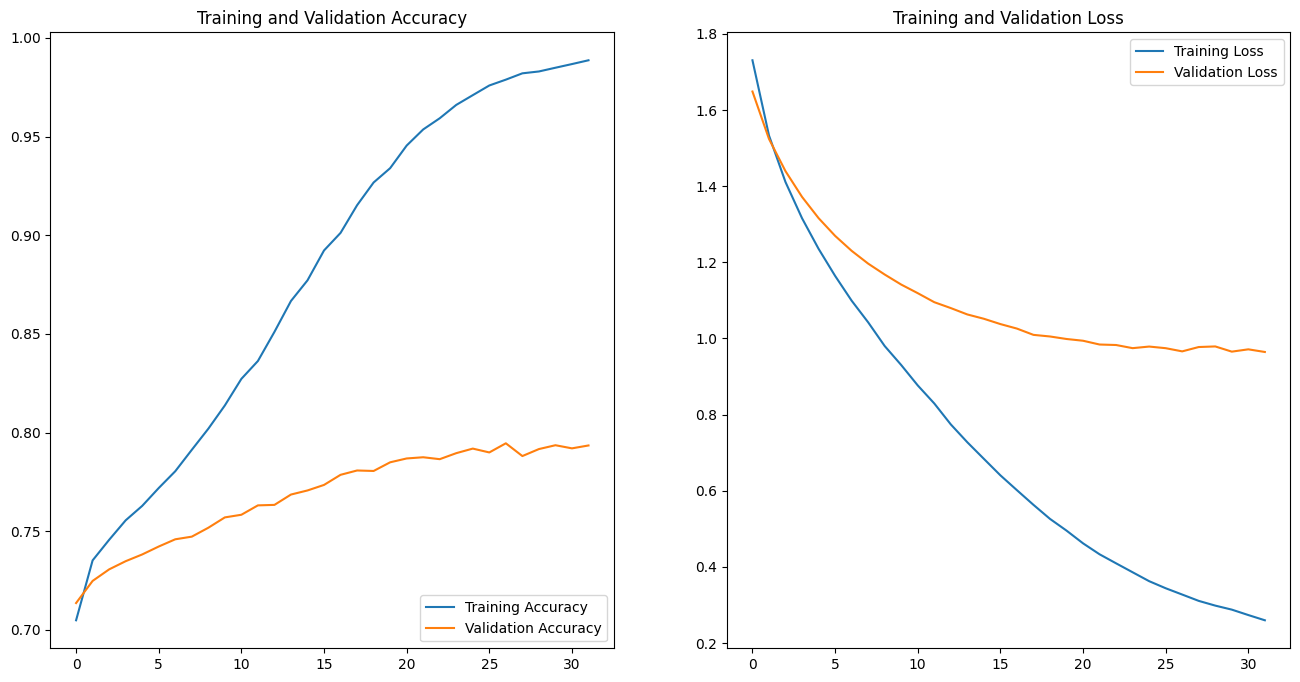

In [199]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(32)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# YOLO

### Функция конвертации аннотация в формат yolo

In [54]:
def convert_to_yolo(annotation_file, output_file, label_maps):
    tree = ET.parse(annotation_file)
    root = tree.getroot()

    size = root.find('size')
    width = int(float(size.find('width').text))
    height = int(float(size.find('height').text))

    with open(output_file, 'w') as f:
        for obj in root.findall('object'):
            label = obj.find('name').text
            label_id = label_maps[label]

            bbox = obj.find('bndbox')
            xmin = int(float(bbox.find('xmin').text))
            ymin = int(float(bbox.find('ymin').text))
            xmax = int(float(bbox.find('xmax').text))
            ymax = int(float(bbox.find('ymax').text))

            x_center = (xmin + xmax) / 2.0 / width
            y_center = (ymin + ymax) / 2.0 / height
            box_width = (xmax - xmin) / width
            box_height = (ymax - ymin) / height

            f.write(f"{label_id} {x_center} {y_center} {box_width} {box_height}\n")

### Подготовка данных для yolo

In [55]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [8]:
label_maps = {}
for i, v in enumerate(breed_list):
    v = v[v.index('-') + 1:].lower().replace('_', ' ')
    label_maps.update({v: i})
label_maps

{'siberian husky': 0,
 'japanese spaniel': 1,
 'standard poodle': 2,
 'giant schnauzer': 3,
 'irish wolfhound': 4,
 'maltese dog': 5,
 'saluki': 6,
 'pekinese': 7,
 'malamute': 8,
 'tibetan mastiff': 9,
 'dandie dinmont': 10,
 'lhasa': 11,
 'cocker spaniel': 12,
 'labrador retriever': 13,
 'sealyham terrier': 14,
 'redbone': 15,
 'pomeranian': 16,
 'irish water spaniel': 17,
 'afghan hound': 18,
 'keeshond': 19,
 'chihuahua': 20,
 'irish setter': 21,
 'beagle': 22,
 'affenpinscher': 23,
 'kelpie': 24,
 'papillon': 25,
 'boston bull': 26,
 'brabancon griffon': 27,
 'ibizan hound': 28,
 'malinois': 29,
 'chesapeake bay retriever': 30,
 'newfoundland': 31,
 'tibetan terrier': 32,
 'otterhound': 33,
 'komondor': 34,
 'english springer': 35,
 'great dane': 36,
 'doberman': 37,
 'cardigan': 38,
 'borzoi': 39,
 'gordon setter': 40,
 'shetland sheepdog': 41,
 'greater swiss mountain dog': 42,
 'irish terrier': 43,
 'west highland white terrier': 44,
 'walker hound': 45,
 'staffordshire bullter

In [58]:
train_dir = 'data/images/train'
val_dir = 'data/images/val'

train_label_dir = 'data/labels/train'
val_label_dir = 'data/labels/val'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

# Создание подкаталогов для каждой породы
for breed in breed_list:
    os.makedirs(os.path.join(train_dir, breed), exist_ok=True)
    os.makedirs(os.path.join(val_dir, breed), exist_ok=True)
    os.makedirs(os.path.join(train_label_dir, breed), exist_ok=True)
    os.makedirs(os.path.join(val_label_dir, breed), exist_ok=True)

In [59]:
def split_and_move_annotations(train_files, val_files):
    train_files = train_files.iloc[:, -2]
    val_files = val_files.iloc[:, -2]
    for file in train_files:
        annotation_filename = os.path.basename(file) + '.txt'  # Добавление расширения файла для формата YOLO
        output_file = os.path.join(train_label_dir, os.path.basename(os.path.dirname(file)), annotation_filename)
        convert_to_yolo(file, output_file, label_maps)
    for file in val_files:
        annotation_filename = os.path.basename(file) + '.txt'  # Добавление расширения файла для формата YOLO
        output_file = os.path.join(val_label_dir, os.path.basename(os.path.dirname(file)), annotation_filename)
        convert_to_yolo(file, output_file, label_maps)
    folder_to_delete = 'data/annotations'
    try:
        shutil.rmtree(folder_to_delete)
        print(f"Папка '{folder_to_delete}' успешно удалена.")
    except OSError as e:
        print(f"Ошибка при удалении папки '{folder_to_delete}': {e}")


def split_and_move_images(train_files, val_files):
    train_files = train_files.iloc[:, 0]
    val_files = val_files.iloc[:, 0]
    for file in train_files:
        breed = os.path.basename(os.path.dirname(file))
        dest_path = os.path.join(train_dir, breed, os.path.basename(file))
        shutil.move(file, dest_path)
    for file in val_files:
        breed = os.path.basename(os.path.dirname(file))
        dest_path = os.path.join(val_dir, breed, os.path.basename(file))
        shutil.move(file, dest_path)
    folder_to_delete = 'data/images/Images'
    try:
        shutil.rmtree(folder_to_delete)
        print(f"Папка '{folder_to_delete}' успешно удалена.")
    except OSError as e:
        print(f"Ошибка при удалении папки '{folder_to_delete}': {e}")

In [60]:
split_and_move_annotations(train_data, val_data)
split_and_move_images(train_data, val_data)

Папка 'data/annotations' успешно удалена.
Папка 'data/images/Images' успешно удалена.


## YOLO обучение

In [9]:
train_dir = 'images/train'
val_dir = 'images/val'

train_label_dir = 'data/labels/train'
val_label_dir = 'data/labels/val'

In [10]:
import yaml

dataset_yaml = {
    'train': train_dir,
    'val': val_dir,
    'nc': len(label_maps),
    'names': list(label_maps.keys()),
}

with open('dog_dataset.yaml', 'w') as f:
    yaml.dump(dataset_yaml, f, default_flow_style=False)



In [4]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device available")

True
1
NVIDIA GeForce RTX 3060 Laptop GPU


In [1]:
import torch
torch.cuda.empty_cache()

In [ ]:

from ultralytics import YOLO
model = YOLO('yolov8s.pt')
results = model.train(data='dog_dataset.yaml', epochs=100, imgsz=640, plots=True,  patience=5, verbose=True,  dropout=0.2)

#! yolo detect train data=dog_dataset.yaml model=yolov10m.pt epochs=100 imgsz=640 plots=True patience=5 verbose=True dropout=0.2 device=0

100%|██████████| 21.5M/21.5M [00:02<00:00, 8.14MB/s]


Ultralytics YOLOv8.2.48 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=dog_dataset.yaml, epochs=100, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

train: Scanning /home/zarzd/development/data/labels/train/n02085620-Chihuahua.cache... 32873 images, 0 backgrounds, 0 corrupt: 100%|██████████| 32873/32873 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/zarzd/development/data/labels/val/n02085620-Chihuahua.cache... 8219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8219/8219 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       4.6G     0.8791      3.825      1.426         27        640: 100%|██████████| 2055/2055 [08:23<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:08<00:00,  3.76it/s]


                   all       8219       8829      0.249      0.359      0.212      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.41G     0.8776      2.654      1.391         20        640: 100%|██████████| 2055/2055 [08:09<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:09<00:00,  3.71it/s]


                   all       8219       8829      0.313      0.443      0.323      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.39G     0.9601      2.589      1.442         29        640: 100%|██████████| 2055/2055 [08:06<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.79it/s]


                   all       8219       8829      0.315      0.404      0.321      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.51G     0.9916      2.556       1.46         24        640: 100%|██████████| 2055/2055 [08:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:08<00:00,  3.74it/s]


                   all       8219       8829      0.423      0.496      0.433      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.38G     0.9453      2.351       1.42         25        640: 100%|██████████| 2055/2055 [08:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.81it/s]


                   all       8219       8829      0.482      0.548      0.526      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.36G     0.9129      2.197      1.396         27        640: 100%|██████████| 2055/2055 [08:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:09<00:00,  3.72it/s]


                   all       8219       8829      0.531      0.594      0.594      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.39G     0.8946      2.096      1.381         26        640: 100%|██████████| 2055/2055 [08:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.84it/s]


                   all       8219       8829      0.579      0.631      0.644      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.51G     0.8743       2.02      1.365         23        640: 100%|██████████| 2055/2055 [08:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.81it/s]


                   all       8219       8829      0.631      0.662      0.692      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.36G     0.8586      1.949      1.355         33        640: 100%|██████████| 2055/2055 [08:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:09<00:00,  3.70it/s]


                   all       8219       8829      0.638      0.688      0.717      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.37G     0.8436      1.881      1.343         30        640: 100%|██████████| 2055/2055 [08:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.79it/s]


                   all       8219       8829      0.669      0.697      0.742      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.39G     0.8417      1.842      1.341         28        640: 100%|██████████| 2055/2055 [08:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:09<00:00,  3.72it/s]

                   all       8219       8829      0.708      0.712      0.765      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.35G       0.83      1.798      1.333         26        640: 100%|██████████| 2055/2055 [08:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:09<00:00,  3.70it/s]

                   all       8219       8829      0.729      0.735      0.792      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.36G     0.8189      1.758      1.325         27        640: 100%|██████████| 2055/2055 [08:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:08<00:00,  3.75it/s]

                   all       8219       8829      0.737      0.746      0.806      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.36G     0.8144      1.729      1.321         25        640: 100%|██████████| 2055/2055 [08:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:08<00:00,  3.74it/s]

                   all       8219       8829      0.748      0.763      0.814      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.38G     0.8054      1.686      1.313         30        640: 100%|██████████| 2055/2055 [08:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:08<00:00,  3.75it/s]

                   all       8219       8829      0.772      0.761      0.829      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.35G     0.7996       1.67      1.308         27        640: 100%|██████████| 2055/2055 [08:04<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:08<00:00,  3.75it/s]

                   all       8219       8829      0.777      0.777      0.841      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.37G     0.7925      1.638      1.302         21        640: 100%|██████████| 2055/2055 [08:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:08<00:00,  3.74it/s]

                   all       8219       8829      0.778      0.786      0.847      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.37G     0.7927      1.622      1.303         25        640: 100%|██████████| 2055/2055 [08:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:08<00:00,  3.73it/s]

                   all       8219       8829      0.794      0.788      0.856      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.39G     0.7828      1.595      1.295         26        640: 100%|██████████| 2055/2055 [08:04<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:08<00:00,  3.77it/s]

                   all       8219       8829      0.809      0.793      0.862      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       4.5G     0.7802      1.569      1.294         18        640: 100%|██████████| 2055/2055 [08:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.88it/s]

                   all       8219       8829      0.816        0.8      0.869       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.37G     0.7765      1.555      1.292         21        640: 100%|██████████| 2055/2055 [08:06<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.83it/s]

                   all       8219       8829      0.829      0.797      0.874      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.36G     0.7737      1.535      1.288         29        640: 100%|██████████| 2055/2055 [07:59<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:05<00:00,  3.91it/s]

                   all       8219       8829      0.826      0.809      0.879      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.39G     0.7698      1.509      1.286         29        640: 100%|██████████| 2055/2055 [08:07<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.87it/s]

                   all       8219       8829       0.83      0.814      0.882      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.34G     0.7631      1.502      1.283         18        640: 100%|██████████| 2055/2055 [08:06<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.84it/s]

                   all       8219       8829      0.834      0.816      0.885      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.38G     0.7556      1.489      1.277         24        640: 100%|██████████| 2055/2055 [08:10<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.82it/s]

                   all       8219       8829      0.831      0.827      0.889      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.36G     0.7561      1.472      1.276         27        640: 100%|██████████| 2055/2055 [08:06<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:11<00:00,  3.59it/s]

                   all       8219       8829      0.837      0.825      0.891       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.39G     0.7517      1.454      1.273         27        640: 100%|██████████| 2055/2055 [08:03<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.82it/s]

                   all       8219       8829      0.829      0.839      0.895      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       4.5G     0.7488      1.438      1.271         22        640: 100%|██████████| 2055/2055 [07:59<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.89it/s]

                   all       8219       8829      0.843      0.832      0.897      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.36G      0.749      1.428       1.27         21        640: 100%|██████████| 2055/2055 [07:57<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:08<00:00,  3.75it/s]

                   all       8219       8829      0.851       0.83      0.899       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.36G     0.7445      1.415      1.268         19        640: 100%|██████████| 2055/2055 [07:57<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:08<00:00,  3.75it/s]

                   all       8219       8829      0.852      0.832        0.9      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.39G     0.7372        1.4      1.262         24        640: 100%|██████████| 2055/2055 [08:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.81it/s]

                   all       8219       8829      0.852      0.838      0.902      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       4.5G     0.7337      1.394      1.259         24        640: 100%|██████████| 2055/2055 [08:06<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.84it/s]

                   all       8219       8829       0.85      0.841      0.903      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.38G     0.7312       1.38      1.258         27        640: 100%|██████████| 2055/2055 [08:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:05<00:00,  3.90it/s]

                   all       8219       8829      0.847      0.847      0.905      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.36G     0.7306      1.373      1.258         26        640: 100%|██████████| 2055/2055 [08:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:08<00:00,  3.77it/s]

                   all       8219       8829      0.849      0.849      0.906      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.38G     0.7283      1.357      1.255         25        640: 100%|██████████| 2055/2055 [08:03<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.81it/s]

                   all       8219       8829      0.849      0.851      0.907      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       4.5G     0.7242      1.346      1.254         27        640: 100%|██████████| 2055/2055 [08:03<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.87it/s]

                   all       8219       8829      0.854      0.849      0.908      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.36G     0.7211      1.335       1.25         27        640: 100%|██████████| 2055/2055 [08:03<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.87it/s]

                   all       8219       8829      0.857      0.848      0.909      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.37G     0.7209       1.33       1.25         25        640: 100%|██████████| 2055/2055 [08:04<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.89it/s]

                   all       8219       8829      0.858      0.848       0.91       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.39G     0.7169      1.318      1.248         25        640: 100%|██████████| 2055/2055 [08:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:05<00:00,  3.90it/s]

                   all       8219       8829      0.856      0.852      0.911      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.35G     0.7128      1.309      1.245         26        640: 100%|██████████| 2055/2055 [08:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:05<00:00,  3.93it/s]

                   all       8219       8829      0.859       0.85      0.912      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.38G     0.7097        1.3      1.242         23        640: 100%|██████████| 2055/2055 [08:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:09<00:00,  3.69it/s]

                   all       8219       8829      0.859      0.853      0.913      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.36G     0.7077      1.284      1.239         29        640: 100%|██████████| 2055/2055 [08:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.84it/s]

                   all       8219       8829      0.865       0.85      0.914      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.38G     0.7014      1.281      1.236         30        640: 100%|██████████| 2055/2055 [08:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:05<00:00,  3.93it/s]

                   all       8219       8829      0.864      0.851      0.915      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.35G     0.6982      1.267      1.235         34        640: 100%|██████████| 2055/2055 [08:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:05<00:00,  3.90it/s]

                   all       8219       8829      0.866      0.851      0.916      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.36G     0.6943      1.253      1.231         29        640: 100%|██████████| 2055/2055 [08:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.83it/s]

                   all       8219       8829      0.867      0.854      0.917      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.36G     0.6922      1.253      1.231         31        640: 100%|██████████| 2055/2055 [07:59<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.88it/s]

                   all       8219       8829      0.871      0.852      0.918      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.38G     0.6897      1.231      1.228         26        640: 100%|██████████| 2055/2055 [07:59<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:05<00:00,  3.93it/s]


                   all       8219       8829      0.869      0.856      0.919      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.35G     0.6861      1.231      1.225         29        640: 100%|██████████| 2055/2055 [07:58<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.83it/s]

                   all       8219       8829      0.869      0.858       0.92      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.37G      0.682      1.221      1.223         18        640: 100%|██████████| 2055/2055 [08:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.80it/s]


                   all       8219       8829      0.868      0.861      0.921      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.36G     0.6807      1.215      1.222         25        640: 100%|██████████| 2055/2055 [07:59<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.85it/s]

                   all       8219       8829      0.874      0.858      0.922       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.38G     0.6769      1.201      1.218         27        640: 100%|██████████| 2055/2055 [07:59<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.85it/s]

                   all       8219       8829      0.876      0.858      0.923      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       4.5G     0.6761      1.194       1.22         18        640: 100%|██████████| 2055/2055 [07:58<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.85it/s]

                   all       8219       8829      0.876      0.859      0.924      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.37G     0.6698       1.18      1.214         20        640: 100%|██████████| 2055/2055 [07:58<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.85it/s]

                   all       8219       8829      0.871      0.865      0.925      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.37G     0.6696      1.179      1.213         21        640: 100%|██████████| 2055/2055 [07:58<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:05<00:00,  3.93it/s]

                   all       8219       8829       0.87      0.869      0.926      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.39G     0.6653       1.17      1.211         26        640: 100%|██████████| 2055/2055 [07:59<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.88it/s]

                   all       8219       8829       0.87      0.873      0.927      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       4.5G      0.664       1.16       1.21         27        640: 100%|██████████| 2055/2055 [07:59<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.83it/s]

                   all       8219       8829      0.871      0.875      0.928      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.37G     0.6587      1.144      1.204         28        640: 100%|██████████| 2055/2055 [07:59<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.82it/s]

                   all       8219       8829      0.872      0.875      0.929      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.35G     0.6562      1.135      1.204         23        640: 100%|██████████| 2055/2055 [07:58<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.88it/s]

                   all       8219       8829      0.874      0.876       0.93      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.38G     0.6548      1.127      1.203         25        640: 100%|██████████| 2055/2055 [08:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:10<00:00,  3.65it/s]

                   all       8219       8829      0.878      0.875      0.931      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       4.5G     0.6531      1.118        1.2         19        640: 100%|██████████| 2055/2055 [07:59<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.81it/s]

                   all       8219       8829      0.878      0.876      0.932      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.37G      0.649      1.118        1.2         24        640: 100%|██████████| 2055/2055 [07:58<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.85it/s]

                   all       8219       8829      0.877      0.877      0.933      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.35G     0.6483      1.103        1.2         27        640: 100%|██████████| 2055/2055 [08:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:10<00:00,  3.64it/s]

                   all       8219       8829      0.879      0.879      0.933       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.38G     0.6428      1.097      1.194         27        640: 100%|██████████| 2055/2055 [08:03<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.82it/s]

                   all       8219       8829      0.882       0.88      0.934      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.34G     0.6449      1.086      1.196         26        640: 100%|██████████| 2055/2055 [08:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.84it/s]

                   all       8219       8829      0.882      0.882      0.935      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.37G      0.639       1.08      1.192         19        640: 100%|██████████| 2055/2055 [08:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:08<00:00,  3.73it/s]

                   all       8219       8829      0.884      0.882      0.936      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.36G     0.6345      1.066      1.189         24        640: 100%|██████████| 2055/2055 [07:59<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:04<00:00,  3.96it/s]

                   all       8219       8829      0.886      0.882      0.937      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       4.4G     0.6299      1.062      1.185         23        640: 100%|██████████| 2055/2055 [07:59<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.82it/s]

                   all       8219       8829      0.886      0.884      0.938      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.34G      0.629      1.044      1.186         28        640: 100%|██████████| 2055/2055 [08:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.78it/s]

                   all       8219       8829      0.886      0.886      0.939      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.37G     0.6265      1.043      1.185         21        640: 100%|██████████| 2055/2055 [08:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:05<00:00,  3.91it/s]

                   all       8219       8829      0.886      0.889       0.94      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.37G     0.6216      1.023       1.18         25        640: 100%|██████████| 2055/2055 [08:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.84it/s]

                   all       8219       8829      0.886      0.892      0.941      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.39G     0.6203      1.024       1.18         32        640: 100%|██████████| 2055/2055 [07:58<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:09<00:00,  3.70it/s]

                   all       8219       8829      0.888      0.892      0.942      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       4.5G      0.618       1.01      1.179         28        640: 100%|██████████| 2055/2055 [08:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:08<00:00,  3.77it/s]

                   all       8219       8829      0.892      0.892      0.943      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.37G     0.6161      1.008      1.177         23        640: 100%|██████████| 2055/2055 [08:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.80it/s]

                   all       8219       8829      0.892      0.894      0.943      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.36G     0.6088     0.9963      1.171         22        640: 100%|██████████| 2055/2055 [08:10<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.85it/s]

                   all       8219       8829      0.894      0.895      0.944       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.39G     0.6121     0.9934      1.175         27        640: 100%|██████████| 2055/2055 [08:04<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.83it/s]

                   all       8219       8829      0.893      0.898      0.945      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       4.5G     0.6078     0.9748      1.171         26        640: 100%|██████████| 2055/2055 [08:06<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.85it/s]

                   all       8219       8829      0.896      0.898      0.946      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.37G     0.6046     0.9695       1.17         27        640: 100%|██████████| 2055/2055 [08:04<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:05<00:00,  3.90it/s]

                   all       8219       8829      0.897        0.9      0.947      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.36G     0.5986     0.9566      1.166         20        640: 100%|██████████| 2055/2055 [08:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:05<00:00,  3.92it/s]

                   all       8219       8829      0.898      0.901      0.948      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.39G     0.5939     0.9441      1.163         27        640: 100%|██████████| 2055/2055 [08:03<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:05<00:00,  3.95it/s]

                   all       8219       8829      0.899      0.902      0.948      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.51G     0.5944     0.9453      1.163         15        640: 100%|██████████| 2055/2055 [08:03<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.80it/s]

                   all       8219       8829        0.9      0.903      0.949       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.37G     0.5877     0.9345      1.159         18        640: 100%|██████████| 2055/2055 [08:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.85it/s]

                   all       8219       8829      0.903      0.902       0.95      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.36G     0.5877     0.9308      1.158         28        640: 100%|██████████| 2055/2055 [07:57<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.84it/s]

                   all       8219       8829      0.903      0.906      0.951      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.39G     0.5846     0.9191      1.156         16        640: 100%|██████████| 2055/2055 [07:54<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.86it/s]

                   all       8219       8829      0.907      0.905      0.952      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       4.5G      0.578     0.9011      1.152         22        640: 100%|██████████| 2055/2055 [07:54<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.87it/s]

                   all       8219       8829      0.908      0.907      0.952      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.37G     0.5757     0.8937      1.149         22        640: 100%|██████████| 2055/2055 [07:57<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:05<00:00,  3.89it/s]

                   all       8219       8829      0.909      0.908      0.953      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.36G     0.5729     0.8933      1.148         21        640: 100%|██████████| 2055/2055 [08:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.85it/s]

                   all       8219       8829      0.909       0.91      0.954       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       4.4G     0.5712     0.8782      1.147         23        640: 100%|██████████| 2055/2055 [07:56<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.84it/s]

                   all       8219       8829      0.911       0.91      0.954      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       4.5G     0.5644     0.8526      1.141         32        640: 100%|██████████| 2055/2055 [07:57<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.88it/s]

                   all       8219       8829      0.912      0.913      0.955      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.37G     0.5649     0.8572      1.143         25        640: 100%|██████████| 2055/2055 [07:57<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:05<00:00,  3.93it/s]

                   all       8219       8829      0.913      0.913      0.956      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.37G     0.5628     0.8471      1.142         24        640: 100%|██████████| 2055/2055 [07:59<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.84it/s]

                   all       8219       8829      0.914      0.915      0.956      0.855


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.38G      0.379     0.3245      1.065          9        640: 100%|██████████| 2055/2055 [08:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.83it/s]

                   all       8219       8829      0.915      0.915      0.957      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.51G     0.3669     0.3013      1.053          9        640: 100%|██████████| 2055/2055 [07:57<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.79it/s]

                   all       8219       8829      0.916      0.917      0.958      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.37G     0.3577       0.29      1.045         10        640: 100%|██████████| 2055/2055 [07:59<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.80it/s]

                   all       8219       8829      0.918      0.917      0.958       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.37G     0.3501     0.2771      1.038         10        640: 100%|██████████| 2055/2055 [07:59<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.85it/s]

                   all       8219       8829      0.919      0.917      0.959      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.39G     0.3439     0.2679      1.032         11        640: 100%|██████████| 2055/2055 [07:56<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:05<00:00,  3.93it/s]

                   all       8219       8829      0.922      0.917       0.96      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.51G     0.3383     0.2596      1.028         10        640: 100%|██████████| 2055/2055 [07:57<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:06<00:00,  3.85it/s]

                   all       8219       8829      0.924      0.918      0.961      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.37G     0.3329      0.254      1.024          9        640: 100%|██████████| 2055/2055 [07:59<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:07<00:00,  3.81it/s]

                   all       8219       8829      0.925      0.919      0.961      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.35G     0.3233     0.2442      1.017          9        640: 100%|██████████| 2055/2055 [07:56<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:08<00:00,  3.74it/s]

                   all       8219       8829      0.928      0.919      0.962      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.38G     0.3223     0.2389      1.014          9        640: 100%|██████████| 2055/2055 [07:54<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:08<00:00,  3.75it/s]

                   all       8219       8829      0.929      0.921      0.963      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       4.5G     0.3168     0.2318       1.01          9        640: 100%|██████████| 2055/2055 [07:55<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 257/257 [01:09<00:00,  3.68it/s]

                   all       8219       8829      0.929      0.922      0.963       0.87



100 epochs completed in 15.267 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.48 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 11172024 parameters, 0 gradients, 28.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 1/257 [00:00<02:36,  1.64it/s]

In [ ]:
"""
model = YOLO("path/to/last.pt") 

results = model.train(resume=True)

! yolo train resume model=runs/detect/train/weights/best.pt
"""

In [3]:
from ultralytics import YOLO

model = YOLO('runs/detect/train/weights/best.pt')

In [2]:
metrics = model.val(device=0, plots=True, imgsz=640, conf=0.25)  # conf=0.25 iou=0.6
metrics.box.maps

Ultralytics YOLOv8.2.48 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 11172024 parameters, 0 gradients, 28.7 GFLOPs


val: Scanning /home/zarzd/development/data/labels/val/n02085620-Chihuahua.cache... 8219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8219/8219 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 514/514 [01:25<00:00,  6.01it/s]


                   all       8219       8829      0.929      0.922      0.953      0.879
        siberian husky         83         92      0.777      0.796      0.827      0.753
      japanese spaniel         76         86      0.965      0.965      0.976      0.889
       standard poodle         72         77      0.922      0.918      0.936      0.867
       giant schnauzer         71         77      0.893      0.909      0.932      0.859
       irish wolfhound         77         94      0.954      0.947      0.974      0.847
           maltese dog         92         99      0.888      0.919      0.953      0.887
                saluki         70         74      0.946      0.946      0.976      0.899
              pekinese         59         59       0.95      0.966      0.982      0.911
              malamute         64         76      0.858      0.776      0.892      0.803
       tibetan mastiff         56         57      0.967      0.947      0.972      0.893
        dandie dinmon

array([    0.75329,     0.88893,     0.86694,     0.85902,     0.84699,     0.88681,     0.89903,     0.91081,     0.80313,     0.89339,     0.90019,     0.79716,     0.91785,     0.87567,     0.88181,     0.85627,     0.93352,     0.89728,     0.94476,     0.91724,     0.85003,     0.89752,     0.87877,     0.91463,
           0.88965,     0.88361,     0.87798,     0.92317,     0.91797,      0.9145,     0.89017,     0.88061,     0.86509,     0.89022,     0.91282,     0.84717,     0.92363,     0.93921,     0.88613,     0.90083,     0.89644,     0.90973,     0.86181,     0.87443,     0.84186,     0.76358,     0.82061,      0.7608,
           0.88297,     0.81055,     0.83164,     0.91123,     0.86268,     0.90063,     0.86805,     0.86465,     0.86152,     0.88675,     0.80192,     0.91097,      0.8831,     0.77721,     0.86017,     0.84861,     0.89064,     0.79689,     0.88041,     0.89886,       0.933,     0.90747,     0.89288,     0.90934,
           0.86149,     0.89341,     0.8751


image 1/1 /home/zarzd/development/data/img_2.jpg: 448x640 1 pomeranian, 95.9ms
Speed: 4.4ms preprocess, 95.9ms inference, 166.3ms postprocess per image at shape (1, 3, 448, 640)


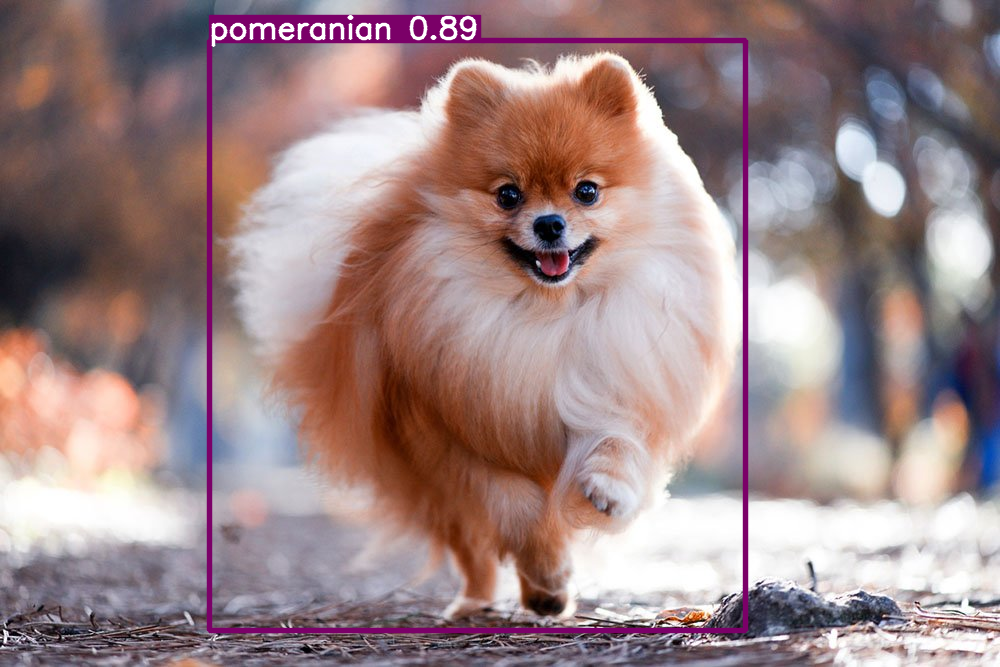

In [2]:
results = model('data/img_2.jpg')
for result in results:
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk

In [6]:
# model.predict('data/img_1.jpg', save=True, show=True)


image 1/1 /home/zarzd/development/data/img_1.jpg: 320x640 1 siberian husky, 1 malamute, 145.5ms
Speed: 4.7ms preprocess, 145.5ms inference, 214.3ms postprocess per image at shape (1, 3, 320, 640)
Results saved to runs/detect/predict6


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'siberian husky', 1: 'japanese spaniel', 2: 'standard poodle', 3: 'giant schnauzer', 4: 'irish wolfhound', 5: 'maltese dog', 6: 'saluki', 7: 'pekinese', 8: 'malamute', 9: 'tibetan mastiff', 10: 'dandie dinmont', 11: 'lhasa', 12: 'cocker spaniel', 13: 'labrador retriever', 14: 'sealyham terrier', 15: 'redbone', 16: 'pomeranian', 17: 'irish water spaniel', 18: 'afghan hound', 19: 'keeshond', 20: 'chihuahua', 21: 'irish setter', 22: 'beagle', 23: 'affenpinscher', 24: 'kelpie', 25: 'papillon', 26: 'boston bull', 27: 'brabancon griffon', 28: 'ibizan hound', 29: 'malinois', 30: 'chesapeake bay retriever', 31: 'newfoundland', 32: 'tibetan terrier', 33: 'otterhound', 34: 'komondor', 35: 'english springer', 36: 'great dane', 37: 'doberman', 38: 'cardigan', 39: 'borzoi', 40: 'gordon setter', 41: 'shetland sheepdog', 42: 'greater swiss mountain do

In [5]:
import cv2
video_path = 'data/video_3.mp4'
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    success, frame = cap.read()
    if success:
        results = model.track(frame, persist=True, show=False, tracker="bytetrack.yaml")

        annotated_frame = results[0].plot()

        cv2.imshow('YOLOv8 Inference', annotated_frame)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
        if cv2.getWindowProperty('YOLOv8 Inference', cv2.WND_PROP_VISIBLE) < 1:
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()


0: 384x640 1 dingo, 47.4ms
Speed: 746.5ms preprocess, 47.4ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dingo, 49.5ms
Speed: 3.4ms preprocess, 49.5ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dingo, 47.3ms
Speed: 3.1ms preprocess, 47.3ms inference, 4.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dingo, 47.1ms
Speed: 3.1ms preprocess, 47.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dingo, 40.7ms
Speed: 3.0ms preprocess, 40.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dingo, 40.7ms
Speed: 3.1ms preprocess, 40.7ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dingo, 40.8ms
Speed: 3.4ms preprocess, 40.8ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dingo, 22.9ms
Speed: 2.7ms preprocess, 22.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640